# <p style="text-align: center;">MIS 284N: Analytics for Unstructured Data</p>
# <p style="text-align: center;">Assignment 1 (Edmunds)</p>
## <p style="text-align: center;">Ally McNulty , Chaitra Setty , Emilio Cabrera , Vishu Agarwal, Yashpreet Kaur</p>

In [2]:
###################################### loading all the required libraries ################################################
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from string import punctuation
from nltk.corpus import stopwords
from sklearn.manifold import MDS
from sklearn import manifold
import sys

# Web scraping code

Source used for scraping the comments : https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans

In [ ]:
#################### installing selenium and adding necessary initializaitons for web scraping #########################
#Selenium is an open-source tool that automates web browsers
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
from selenium import webdriver 
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

#WebDriver is a browser automation framework that works with open source APIs
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
#loading the webdriver
wd = webdriver.Chrome('chromedriver',options=chrome_options)

#web scraping algorithm 
wd.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans')
comment_counter = 0 
page_counter = 1
ids = []

comments = pd.DataFrame(columns = ['Date','comments']) 

while comment_counter <= 5000:
  
  comment_ids = []

  ids = wd.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
  for i in ids:
    comment_ids.append(i.get_attribute('id'))

  for x in comment_ids:
    #Extract dates from for each user on a page
    user_date = wd.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span/a/time')[0]
    date = user_date.get_attribute('title')

    #Extract Message for each user on a page
    user_message = wd.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
    comment = user_message.text

    #storing date and comment in a data frame
    comments.loc[len(comments)] = [date,comment]

  comment_counter += len(comment_ids)
  page_counter += 1
  path = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'+'/p'+str(page_counter)
  wd.get(path)

comments

comments.to_csv("results.csv", sep="\t")
!ls
from google.colab import files
files.download("results.csv")

# Cleaning the 5000 comments from edmunds

In [3]:
############################### loading all the comments in a data frame ##########################################
df = pd.read_csv('results.csv',sep='\t', index_col = 0)

In [4]:
##################################### processing and tokenizing the comments #############################################
#dropping null records 
df = df.dropna()

#filtering df for first 5000 comments 
df = df[:5000]

#defining a function to remove punctuations
def removepunc(item):
    for p in punctuation:
        item = item.lstrip().replace(p,'')
    return item

#defining a function to convert comments to lower case 
def lowerize(x):
  return x.lower()

#applying the defined functions to the comments data frame
df['comments'] = df['comments'].apply(removepunc).apply(lowerize)

#tokenizing the cleaned comments and storing them in a new column 
df['comments_token'] = df['comments'].apply(nltk.word_tokenize)
df.reset_index(inplace  = True)

In [5]:
####################### creating a bag of words to calculate word frequency distribution #############################
#creating a list of tokens across all the comments 
words = []
for i in range(len(df)):
    words += df['comments_token'][i]

#calculating count of each token 
from nltk import FreqDist
fd = nltk.FreqDist(words)

## Task A: 

Once you fetch the data, test if the data support Zipf’s law. Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

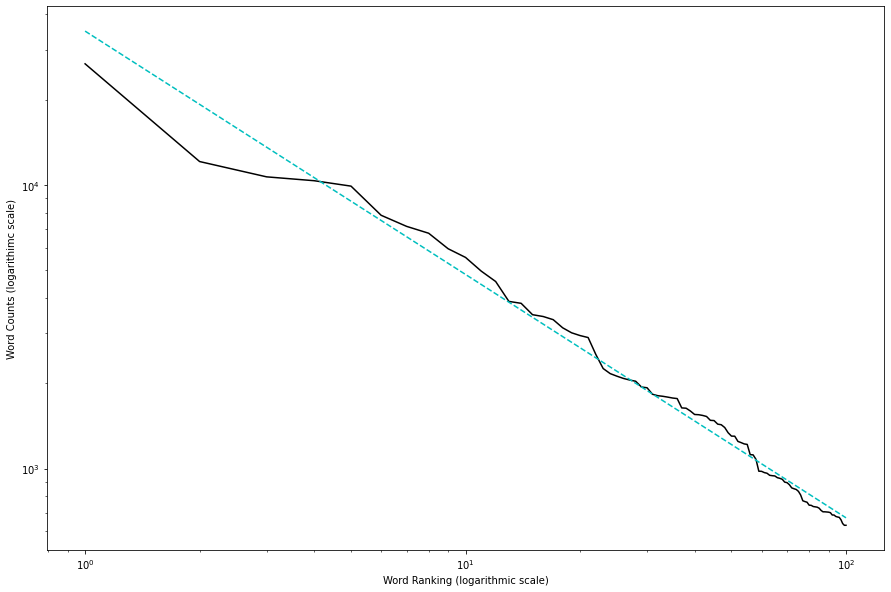

In [6]:
######################################## plot and visualize zipf's law ###################################################

#creating ranks based on the word counts
ranks_counts = [(ranks + 1, counts) for ranks, counts in enumerate([counts for words, counts in fd.most_common(100)])]
ranks, counts = zip(*ranks_counts)

#plotting the rank based on word counts 
plt.figure(figsize=(15, 10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Word Ranking (logarithmic scale)')
plt.ylabel('Word Counts (logarithimc scale)')
plt.plot(ranks, counts, 'k-')

#adding regression line for theoretical prediction of Zipf's law 
logR = np.log(np.asarray(ranks))
logC = np.log(np.asarray(counts))
m, c = np.polyfit(logR, logC, 1)
y_fit = np.exp(m * logR + c)
plt.plot(ranks, y_fit, 'c--')

## Task B: 
Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file.   

In [35]:
##################################### replacing the models with brand ##############################################
#loading the brand model mapping file in a data frame
models = pd.read_csv("car_models.csv", header = None, names = ['brand','model'])

#defining a function to replace model with brand 
def model_to_brand(s):
    for i in models.index.values:
        s = s.replace(models["model"][i].lower(),models["brand"][i].lower())
    return s

#levaraging the defined function to replace car model with brand 
df['comments_model_replace'] = df['comments'].apply(model_to_brand) #problem with g35 model

#tokenizing the updated comments 
df['tokens_model_replace'] = df['comments_model_replace'].apply(nltk.word_tokenize)

##################################### removing the stop words from the final tokens #####################################
stop_words = set(stopwords.words('english'))

#defining a function to remove the stop words 
def remove_stopwords(s):
    return [w for w in s if w not in stop_words]

#levaraging the function to remove the stop words from tokens 
df['tokens_model_replace'] = df['tokens_model_replace'].apply(remove_stopwords)

######################################### identifying the top 10 brands #############################################
#creating a list of tokens across all the comments 
words = []
for i in range(len(df)):
    words += df['tokens_model_replace'][i]

#calculating count of each token 
from nltk import FreqDist
fd = nltk.FreqDist(words)

#identifying all unique brands
unique_brands = models['brand'].drop_duplicates().tolist()

#counting frequency of each brand (Contains some extra words as well)
top_brand = [(key,count) for key,count in fd.most_common(10000) if key in unique_brands]
top_brand[1:20]

#storing the top 10 brands in a list and getting their frequency count 
top_10_brands = ['bmw','acura','audi','honda','infiniti','nissan','toyota','subaru','volkswagen','mercedes-benz']
brands = pd.DataFrame([(brand, freq) for brand,freq in fd.most_common(10000) if brand in top_10_brands], columns = ['Brand','Frequency'])
brands.set_index('Brand')

,Frequency
Brand,
bmw,2598
acura,877
audi,852
honda,665
infiniti,553
nissan,501
toyota,438
subaru,373
volkswagen,309


# Task C: 
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

In [37]:
####################### creating an dataframe to store lift ratio between the top 10 brands ############################
lift_df = pd.DataFrame(columns = ['brand_x','brand_y','lift_value'])
for i in top_10_brands:
  for j in top_10_brands:
    if i != j:
      lift_df.loc[len(lift_df)] = [i,j,'']

########################################## calculate lift values ############################################
N = len(df)
for i in range(len(lift_df)):
  num_a = 0
  num_b = 0 
  num_ab = 0 
  for j in range(len(df)):
    if lift_df['brand_x'][i] in df['tokens_model_replace'][j]:
      num_a += 1
    if lift_df['brand_y'][i] in df['tokens_model_replace'][j]:
      num_b += 1
    if lift_df['brand_x'][i] in df['tokens_model_replace'][j] and lift_df['brand_y'][i] in df['tokens_model_replace'][j]:
      num_ab += 1 
  lift_df['lift_value'][i] = ((num_ab*N)/(num_a*num_b))

################################ creating a table containing the lift values ########################################
lift_matrix = pd.pivot_table(lift_df, index = 'brand_x', columns = 'brand_y', values = 'lift_value', aggfunc=sum)
lift_matrix

brand_y,acura,audi,bmw,honda,infiniti,mercedes-benz,nissan,subaru,toyota,volkswagen
brand_x,,,,,,,,,,
acura,NaN,2.236136,1.527117,2.555584,3.058756,2.098720,2.258423,2.150131,1.788909,1.778447
audi,2.236136,NaN,1.714495,1.379256,2.771273,3.424474,1.557309,1.791328,1.221001,4.639001
bmw,1.527117,1.714495,NaN,1.272218,2.020074,1.961294,1.252293,1.208141,1.443001,1.555996
honda,2.555584,1.379256,1.272218,NaN,1.395445,1.700836,3.968038,1.519996,3.903201,2.122793
infiniti,3.058756,2.771273,2.020074,1.395445,NaN,2.822242,2.495998,1.805998,1.110289,2.196770
mercedes-benz,2.098720,3.424474,1.961294,1.700836,2.822242,NaN,1.670410,1.074345,2.039550,3.430364
nissan,2.258423,1.557309,1.252293,3.968038,2.495998,1.670410,NaN,1.517378,3.796868,2.817120
subaru,2.150131,1.791328,1.208141,1.519996,1.805998,1.074345,1.517378,NaN,1.373626,2.530364
toyota,1.788909,1.221001,1.443001,3.903201,1.110289,2.039550,3.796868,1.373626,NaN,2.134967


# Task D: 
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub). 

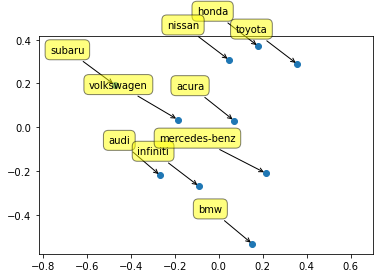

In [38]:
###################################### calculating dissimilarity index ######################################################
dissim = 1/lift_matrix
np.fill_diagonal(dissim.values, 0)

########################### fitting MDS scaling on dissimilar matrix and plotting it ###########################################
model = MDS(n_components=2, dissimilarity='precomputed', max_iter=700, random_state=1)
out = model.fit_transform(dissim)
plt.scatter(out[:, 0], out[:, 1])
plt.axis('equal')

for label, x, y in zip(list(dissim.index), out[:, 0], out[:, 1]): 
    plt.annotate(label,xy = (x, y), xytext = (-30, 30), textcoords = 'offset points', ha = 'right', va = 'bottom', 
    bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
    arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

# Task E: 
What insights can you offer to your client from your analyses in Tasks C and D 

We observe that there are top five brand-pairs that appaear together on social media conversations based on the lift values:

1. Volkswagen & Audi (4.639001)
2. Honda & Nissan (3.968038)
3. Honda & Toyota (3.903201)
4. Toyota & Nissan (3.796868)
5. Mercedes-benz & Volkswagen (3.430364)

These appear to be the combination of cars that the customers are comparing/contemplating on buying.

We can see that these brand-pairs appear to be in the same clusters on the MDS map. The cluster at the top comprises of nissan, honda and toyota. These three brands appear together as high lift values pairs. In the next cluster, acura, volkswagen, mercedes-benz, audi and infiniti appear together, of which volswagen-audi and mercedes-benz-volkswagen appear among the high lift value pairs.

Also, we note that people are comparing high-tier cars like audi and mercedez-benz to the mid-tier cars like volkswagen which might be because they are curious about the features which differ in mid-tier vs high-tier cars. It could also be because they are planning to switch from mid-tier to high-tier or vice versa.

Another basis for clusters' similarity appear to be the origin of manufacturers. For eg: nissan, honda and toyota are Japanese manufacturers while acura, volkswagen, mercedes-benz, audi and infiniti are German manufacturers.

# Task F: 
What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

In [39]:
######################### looking at the most common words to identify prominent attributes #################################################
most_common_words = pd.DataFrame(columns = ['word','count']) 
for a,b in fd.most_common(2000):
    most_common_words.loc[len(most_common_words)] = [a,b]
    
#exporting the csv file containing most common words to identify prominent attributes
most_common_words.to_csv ('most_common_words.csv', index = False, header=True)

#storing the prominent attributes in a list
attributes = ['performance','luxury','engine','handling','interior']

#frequency of 5 most frequently mentioned attribute
attribute_pd = pd.DataFrame([(att, fd[att]) for att in attributes], columns = ['Attribute','Frequency'])
attribute_pd.set_index('Attribute')

,Frequency
Attribute,
performance,929
luxury,702
engine,616
handling,513
interior,509


In [40]:
############################# calculating lift between these attributes and top brands ##################################
#creating an dataframe to store lift ratio between the top 10 brands 
brand_association = pd.DataFrame(columns = ['brand','attributes','lift_value'])

for i in top_10_brands:
    for j in attributes:
        brand_association.loc[len(brand_association)] = [i,j,'']

################################ defining a function to calcualte lift values #######################################
N = len(df)
for i in range(len(brand_association)):
    num_a = 0
    num_b = 0 
    num_ab = 0 
    for j in range(len(df)):
        if brand_association['brand'][i] in df['tokens_model_replace'][j]:
            num_a += 1
        if brand_association['attributes'][i] in df['tokens_model_replace'][j]:
            num_b += 1
        if brand_association['brand'][i] in df['tokens_model_replace'][j] and brand_association['attributes'][i] in df['tokens_model_replace'][j]:
            num_ab += 1 
        if num_a*num_b == 0:
            brand_association['lift_value'][i] = 0.01
        else:
            brand_association['lift_value'][i] = ((num_ab*N)/(num_a*num_b))

#creating a pivot table containing lift values between brands and attributes
asso_matrix = pd.pivot_table(brand_association, index = 'brand', columns = 'attributes', values = 'lift_value', aggfunc=sum)
asso_matrix

attributes,engine,handling,interior,luxury,performance
brand,,,,,
acura,1.597981,1.486885,1.464604,1.985448,1.490757
audi,1.812645,1.498501,2.143781,1.724733,1.438666
bmw,1.509064,1.679769,1.199414,1.317451,1.500594
honda,1.467096,1.490313,1.506498,1.732811,1.508055
infiniti,1.532765,1.312159,1.780141,1.713562,1.570105
mercedes-benz,1.685051,1.451063,1.143455,2.066789,1.058067
nissan,1.657275,1.035509,1.408560,1.638783,1.308769
subaru,1.227021,0.999001,2.389789,3.287772,1.748252
toyota,1.767760,1.978973,1.392370,2.384511,1.443001


## Task G: 
What advice will you give to your client from Task F? For this assignment, you can assume that all sentiments are positive. 

The most imporatant attributes that the customers are considering when evaluating a car for a potential puchase (and the top brands associated per attribute) are as below:

- Performace (Subaru)
- Luxury (Subaru)
- Engine (Audi)
- Handling (Toyota)
- Interior (Subaru)

Assuming all the sentiments are positive, we observe that Subaru is the most discussed brand for 3 top attributes; Performance, Luxury and Interior. For attributes Engine and Handling, Audi and Toyota respectively are the most discussed brands.

Our advice to the client would be that they choose Subaru as benchmark for Performance, Luxury and Interior attributes, Audi for Engine and Toyota for Handling. This way they will be able to design attributes in a car which are liked by most of the people.

## Task H: 
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [41]:
######################## creating a list of words/phrases potentially depicting aspiration #############################
aspirational_words = ['desire','like to','love to have','aspire to','dream car','dreaming','dream of','dream to','wish', 'hope to','future car']

################### creating function to replace aspirational words/phrases to aspiration ############################
def aspirational_words_replace(s):
    for words in aspirational_words:
        if words in s:
            s = s.replace(words,'aspiration')
    return s

######################## using the function to replace the words and tokenizing the comments ###########################################
df['final_comments'] = df['comments_model_replace'].apply(aspirational_words_replace)
df['final_tokens'] = df['final_comments'].apply(nltk.word_tokenize)
df

##################### creating an dataframe to store aspiration lift values for top 10 brands #########################
brand_attribute = pd.DataFrame(columns = ['brand','aspiration_lift'])

for i in top_10_brands:
    brand_attribute.loc[len(brand_attribute)] = [i,'']

###################################### calculating the lift values ###################################################
N = len(df)
for i in range(len(brand_attribute)):
    num_a = 0
    num_b = 0 
    num_ab = 0 
    for j in range(len(df)):
        if brand_attribute['brand'][i] in df['final_tokens'][j]:
            num_a += 1
        if 'aspiration' in df['final_tokens'][j]:
            num_b += 1
        if brand_attribute['brand'][i] in df['final_tokens'][j] and 'aspiration' in df['final_tokens'][j]:
            num_ab += 1 
        if num_a*num_b == 0:
            brand_attribute['aspiration_lift'][i] = 0.01
        else:
            brand_attribute['aspiration_lift'][i] = ((num_ab*N)/(num_a*num_b))
brand_attribute.set_index('brand')

,aspiration_lift
brand,
bmw,1.404287
acura,1.744186
audi,1.201923
honda,1.346604
infiniti,2.137306
nissan,1.495017
toyota,1.682692
subaru,1.201923
volkswagen,1.461988
